# Training an LSTM model on books dataset

First we import necessary packages for our project

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

Set `seaborn` for better data visualization

In [2]:
sns.set()

## Preparing Dataset

Initialize the project root, data, and model related directories. `processed_data` directory contains selected books from renowned authors only.

In [11]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'processed_data/'
model_home = project_root / 'models/bn_lstm'

plot_dir = model_home / 'plots'
history_and_tokenizer_dir = model_home / 'history_and_tokenizer'
model_saved_dir = model_home / 'model'

os.makedirs(model_home, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(history_and_tokenizer_dir, exist_ok=True)
os.makedirs(model_saved_dir, exist_ok=True)

Get list of files in the data directory

In [5]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [6]:
random.shuffle(filenames)
filenames = filenames[:100]

Split the files for training and testing. We are keeping 20% for testing and 80% for training.

In [5]:
train_test_split = 0.2
train_size = int(len(filenames) * train_test_split)
training_filenames = filenames[:-train_size]
test_filenames = filenames[-train_size:]

Now we create a function that creates a tokenizer with `max_words`, fit it on training files and save to `model_dir`.

In [8]:
def create_tokenizer(files, max_words, model_dir):
    tokenizer = Tokenizer(num_words=max_words)
    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().split('\n')
            tokenizer.fit_on_texts(lines)
    save_path = history_and_tokenizer_dir / f'tokenizer_{max_words}_words.pickle'
    # save the tokenizer in model dir
    with open(save_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return tokenizer

Define max words and max sequence length

In [14]:
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

Now create the tokenizer calling the function and passing the defined constants

In [8]:
tokenizer = create_tokenizer(training_filenames, MAX_WORDS, model_dir)

100%|███████████████████████████████████████████| 80/80 [00:10<00:00,  7.71it/s]


`create_dataset` creates a dataset from given `files` and returns two variables - `predictors` which is a sequence of previous words of length `max_sequence_length - 1` and `labels` which is an integer between 0 to `max_words + 1`.
Note that, converting to categorical variables leads to `MemoryError` since it tries to create a sequence of `number of elements in training or test set * (MAX_WORDS + 1)` shape. We are following [this blog](https://medium.com/deep-learning-with-keras/which-activation-loss-functions-in-multi-class-clasification-4cd599e4e61f) and keeping the label as an integer.

In [9]:
def create_dataset(tokenizer, files, max_sequence_length):
    input_sequences = []

    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().split('\n')
            token_list = tokenizer.texts_to_sequences(lines)
            for tokens in token_list:
                for i in range(1, len(tokens)):
                    # keep only sequences of length <= max_sequence_length
                    n_gram_sequence = tokens[max(0, i+1-max_sequence_length):i+1]
                    input_sequences.append(n_gram_sequence)

    # pad sequences with 0s so that all sequences have same length
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequences, maxlen=max_sequence_length, padding='pre')

    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    del input_sequences
    return predictors, label

Now we create training dataset `X_train` and `y_train` from training files and test dataset `X_test` and `y_test` from test files.

In [10]:
X_train, y_train = create_dataset(tokenizer, training_filenames, MAX_SEQUENCE_LENGTH)
X_test, y_test = create_dataset(tokenizer, test_filenames, MAX_SEQUENCE_LENGTH)

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.84it/s]


## Creating and Training Model

We create three sequential LSTM models with different parameters and architectures, and compile the models with loss `sparse_categorical_crossentropy`, optimizer `adam` and metric `sparse_categorical_accuracy`. We are using sparse categorical crossentropy since the values are integers, not one-hot encoded, see this question on [stackexchange](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other) for details.

In [15]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(150),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model1.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam', metrics=['sparse_categorical_accuracy'])

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(150, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(150, dropout=0.2),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model2.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam', metrics=['sparse_categorical_accuracy'])

model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(64, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(64, dropout=0.2),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model3.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam', metrics=['sparse_categorical_accuracy'])

We set callback `EarlyStopping` that monitors `val_loss` for 10 epochs and stops training if it does not improve.

In [16]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, mode='auto')

Start training the models and store the training results. We are using a batch size of 1024 and using 20% of training data for validation. We are running the training for 50 epochs and using `EarlyStopping` callback.

In [17]:
history1 = model1.fit(X_train, y_train, batch_size=1024, epochs=50,
                      validation_split=0.2, callbacks=[earlystop])

history2 = model2.fit(X_train, y_train, batch_size=1024, epochs=50,
                      validation_split=0.2, callbacks=[earlystop])

history3 = model3.fit(X_train, y_train, batch_size=1024, epochs=50,
                      validation_split=0.2, callbacks=[earlystop])

Epoch 1/50


2022-04-06 17:42:53.734709: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1517870112 exceeds 10% of free system memory.
2022-04-06 17:42:57.062313: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


1862/1863 [============================>.] - ETA: 0s - loss: 7.4560 - sparse_categorical_accuracy: 0.0300
Epoch 1: val_loss improved from inf to 7.15031, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


2022-04-06 17:47:54.617543: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1863/1863 [==============================] - 302s 160ms/step - loss: 7.4560 - sparse_categorical_accuracy: 0.0300 - val_loss: 7.1503 - val_sparse_categorical_accuracy: 0.0492
Epoch 2/50
1862/1863 [============================>.] - ETA: 0s - loss: 6.7406 - sparse_categorical_accuracy: 0.0637
Epoch 2: val_loss improved from 7.15031 to 6.89255, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1863/1863 [==============================] - 298s 160ms/step - loss: 6.7406 - sparse_categorical_accuracy: 0.0637 - val_loss: 6.8925 - val_sparse_categorical_accuracy: 0.0663
Epoch 3/50
1862/1863 [============================>.] - ETA: 0s - loss: 6.4439 - sparse_categorical_accuracy: 0.0796
Epoch 3: val_loss improved from 6.89255 to 6.78022, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1863/1863 [==============================] - 296s 159ms/step - loss: 6.4439 - sparse_categorical_accuracy: 0.0796 - val_loss: 6.7802 - val_sparse_categorical_accuracy: 0.0726
Epoch 4/50
1862/1863 [============================>.] - ETA: 0s - loss: 6.2501 - sparse_categorical_accuracy: 0.0889
Epoch 4: val_loss improved from 6.78022 to 6.71337, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1863/1863 [==============================] - 296s 159ms/step - loss: 6.2501 - sparse_categorical_accuracy: 0.0889 - val_loss: 6.7134 - val_sparse_categorical_accuracy: 0.0766
Epoch 5/50
1862/1863 [============================>.] - ETA: 0s - loss: 6.0987 - sparse_categorical_accuracy: 0.0962
Epoch 5: val_loss improved from 6.71337 to 6.67940, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1863/1863 [==============================] - 296s 159ms/step - loss: 6.0987 - sparse_categorical_accuracy: 0.0962 - val_loss: 6.6794 - val_sparse_categorical_accuracy: 0.0791
Epoch 6/50
1862/1863 [============================>.] - ETA: 0s - loss: 5.9775 - sparse_categorical_accuracy: 0.1021
Epoch 6: val_loss improved from 6.67940 to 6.66253, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1863/1863 [==============================] - 296s 159ms/step - loss: 5.9775 - sparse_categorical_accuracy: 0.1021 - val_loss: 6.6625 - val_sparse_categorical_accuracy: 0.0816
Epoch 7/50
1862/1863 [============================>.] - ETA: 0s - loss: 5.8765 - sparse_categorical_accuracy: 0.1074
Epoch 7: val_loss improved from 6.66253 to 6.66054, saving model to /home/shafquat/bangla-next-word-prediction/models/bn_lstm


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


1863/1863 [==============================] - 296s 159ms/step - loss: 5.8765 - sparse_categorical_accuracy: 0.1074 - val_loss: 6.6605 - val_sparse_categorical_accuracy: 0.0818
Epoch 8/50
1862/1863 [============================>.] - ETA: 0s - loss: 5.7901 - sparse_categorical_accuracy: 0.1117
Epoch 8: val_loss did not improve from 6.66054
1863/1863 [==============================] - 294s 158ms/step - loss: 5.7900 - sparse_categorical_accuracy: 0.1117 - val_loss: 6.6722 - val_sparse_categorical_accuracy: 0.0822
Epoch 9/50
1862/1863 [============================>.] - ETA: 0s - loss: 5.7122 - sparse_categorical_accuracy: 0.1164
Epoch 9: val_loss did not improve from 6.66054
1863/1863 [==============================] - 294s 158ms/step - loss: 5.7123 - sparse_categorical_accuracy: 0.1164 - val_loss: 6.6833 - val_sparse_categorical_accuracy: 0.0824
Epoch 10/50
1862/1863 [============================>.] - ETA: 0s - loss: 5.6418 - sparse_categorical_accuracy: 0.1207
Epoch 10: val_loss did not im

2022-04-06 19:06:31.986462: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1517870112 exceeds 10% of free system memory.


1863/1863 [==============================] - ETA: 0s - loss: 7.5646 - sparse_categorical_accuracy: 0.0220
Epoch 1: val_loss did not improve from 6.66054
1863/1863 [==============================] - 542s 290ms/step - loss: 7.5646 - sparse_categorical_accuracy: 0.0220 - val_loss: 7.2939 - val_sparse_categorical_accuracy: 0.0383
Epoch 2/50
1863/1863 [==============================] - ETA: 0s - loss: 6.9224 - sparse_categorical_accuracy: 0.0472
Epoch 2: val_loss did not improve from 6.66054
1863/1863 [==============================] - 541s 290ms/step - loss: 6.9224 - sparse_categorical_accuracy: 0.0472 - val_loss: 7.0453 - val_sparse_categorical_accuracy: 0.0523
Epoch 3/50
1863/1863 [==============================] - ETA: 0s - loss: 6.6501 - sparse_categorical_accuracy: 0.0611
Epoch 3: val_loss did not improve from 6.66054
1863/1863 [==============================] - 541s 290ms/step - loss: 6.6501 - sparse_categorical_accuracy: 0.0611 - val_loss: 6.9252 - val_sparse_categorical_accuracy: 0

2022-04-06 22:18:45.607906: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1517870112 exceeds 10% of free system memory.


1862/1863 [============================>.] - ETA: 0s - loss: 7.7130 - sparse_categorical_accuracy: 0.0172
Epoch 1: val_loss did not improve from 6.66054
1863/1863 [==============================] - 284s 151ms/step - loss: 7.7130 - sparse_categorical_accuracy: 0.0172 - val_loss: 7.4863 - val_sparse_categorical_accuracy: 0.0303
Epoch 2/50
1862/1863 [============================>.] - ETA: 0s - loss: 7.1774 - sparse_categorical_accuracy: 0.0382
Epoch 2: val_loss did not improve from 6.66054
1863/1863 [==============================] - 281s 151ms/step - loss: 7.1774 - sparse_categorical_accuracy: 0.0382 - val_loss: 7.1665 - val_sparse_categorical_accuracy: 0.0467
Epoch 3/50
1862/1863 [============================>.] - ETA: 0s - loss: 6.8663 - sparse_categorical_accuracy: 0.0523
Epoch 3: val_loss did not improve from 6.66054
1863/1863 [==============================] - 281s 151ms/step - loss: 6.8663 - sparse_categorical_accuracy: 0.0523 - val_loss: 7.0396 - val_sparse_categorical_accuracy: 0

Save the history objects for later uses.

In [19]:
with open(str(history_and_tokenizer_dir / 'model_1_history'), 'wb') as history_pkl:
    pickle.dump(history1, history_pkl)
    
with open(str(history_and_tokenizer_dir / 'model_2_history'), 'wb') as history_pkl:
    pickle.dump(history2, history_pkl)

with open(str(history_and_tokenizer_dir / 'model_3_history'), 'wb') as history_pkl:
    pickle.dump(history3, history_pkl)


INFO:tensorflow:Assets written to: ram://8b4cd81f-b734-473e-9d73-18dec6a3af41/assets


INFO:tensorflow:Assets written to: ram://8b4cd81f-b734-473e-9d73-18dec6a3af41/assets


INFO:tensorflow:Assets written to: ram://425f64b2-92ea-49d4-9ee7-cb71306df022/assets


INFO:tensorflow:Assets written to: ram://425f64b2-92ea-49d4-9ee7-cb71306df022/assets


INFO:tensorflow:Assets written to: ram://ebb99041-5414-46b5-baee-ead4deac2b77/assets


INFO:tensorflow:Assets written to: ram://ebb99041-5414-46b5-baee-ead4deac2b77/assets


Finally we evaluate the models on test data with batch size of 1024

In [20]:
eval1 = model1.evaluate(X_test, y_test, batch_size=1024)
print("Model 1:", eval1)
eval2 = model2.evaluate(X_test, y_test, batch_size=1024)
print("Model 2:", eval2)
eval3 = model3.evaluate(X_test, y_test, batch_size=1024)
print("Model 3:", eval3)

318/318 [==============================] - 17s 53ms/step - loss: 7.0373 - sparse_categorical_accuracy: 0.0633
Model 1: [7.037341117858887, 0.06326504051685333]
318/318 [==============================] - 30s 93ms/step - loss: 6.9048 - sparse_categorical_accuracy: 0.0644
Model 2: [6.904751777648926, 0.06438510119915009]
318/318 [==============================] - 15s 46ms/step - loss: 6.9106 - sparse_categorical_accuracy: 0.0618
Model 3: [6.9105544090271, 0.06180649995803833]


And save the best `model`.

In [21]:
model2.save(str(model_saved_dir))

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/assets


## Visualizing accuracy and loss changes per epochs on training and validation data

Next, we plot the training accuracy and loss for each model. The function `plot_history` takes a history object and a title and creates plots for its validation and training accuracy and loss and saves it.

In [9]:
def plot_history(history, title):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
    plt.title(title + ' Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Sparse Categorical Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig(str(plot_dir / f'{title}_sparse_categorical_accuracy.png'), dpi=fig.dpi)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig(str(plot_dir / f'{title}_sparse_categorical_loss.png'), dpi=fig.dpi)

Now we pass three history objects with their titles to the function

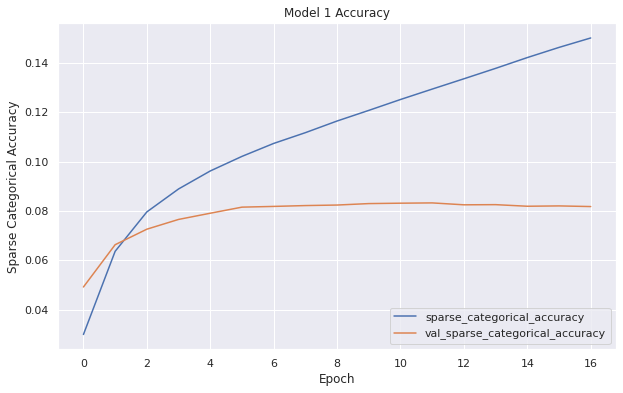

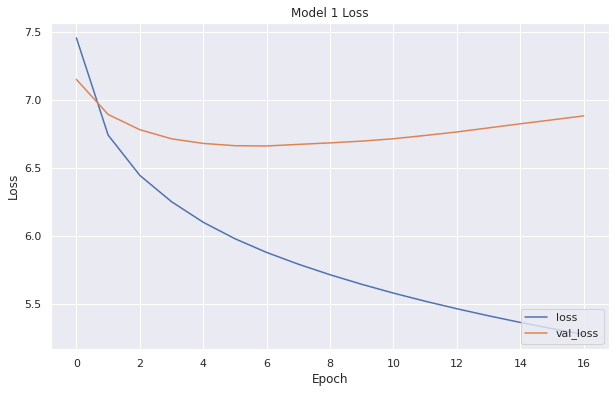

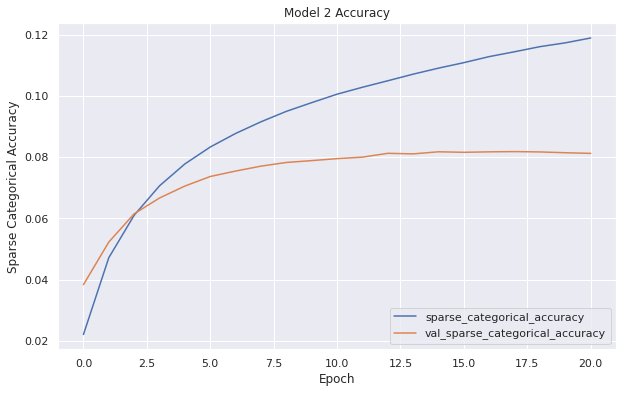

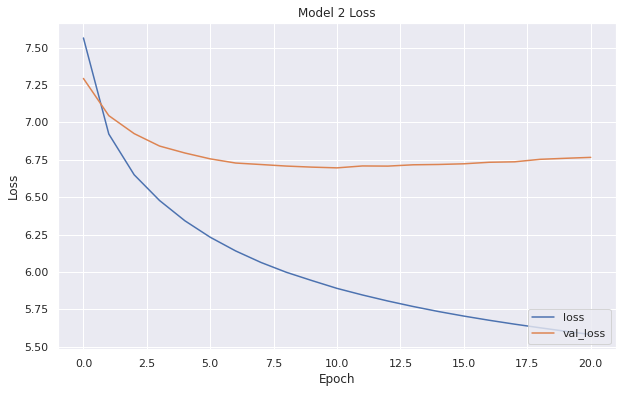

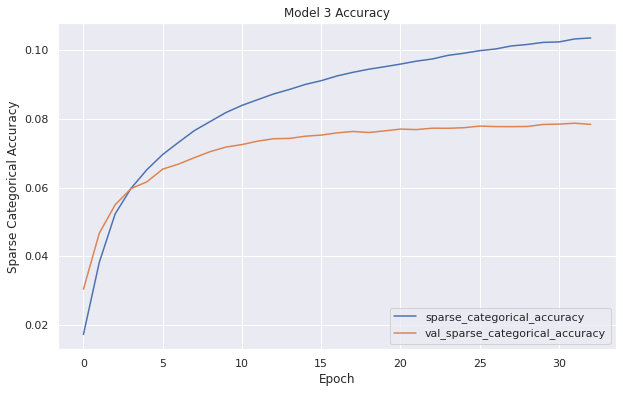

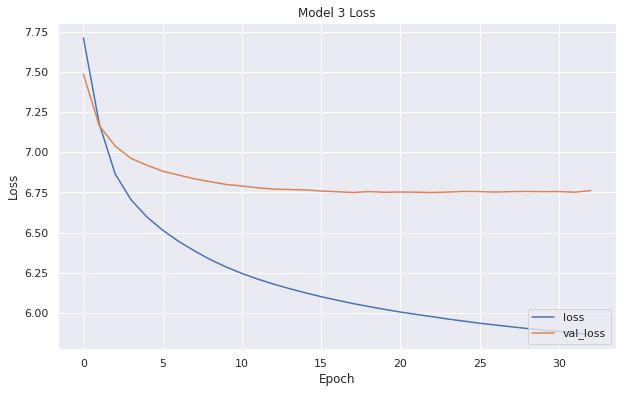

In [9]:
plot_history(history1, 'Model 1')
plot_history(history2, 'Model 2')
plot_history(history3, 'Model 3')

## Testing the model with actual data

`predict_next_words` function takes model, tokenizer and text as function argument and returns top 5 next words predicted by the model

In [12]:
def predict_next_words(model, tokenizer, text):
    # tokenize the text
    tokenized_sequence = tokenizer.texts_to_sequences([text])
    # pre-pad with 0's to make it of size MAX_SEQUENCE_LENGTH - 1
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sequence,
                                                                maxlen=MAX_SEQUENCE_LENGTH - 1,
                                                                padding='pre')
    # predict using model
    predictions = model.predict(input_sequences)
    ids = np.argsort(predictions, axis=1)[:,-5:] # indices of the top 5 predictions
    # print next word with score
    for id in ids[0]:
        print(tokenizer.index_word[id], "->", predictions[:, id].squeeze())

Load `model` and `tokenizer` from files

In [ ]:
model = tf.keras.models.load_model(str(model_saved_dir))
with open(str(history_and_tokenizer_dir / f'tokenizer_{MAX_WORDS}_words.pickle'), 'rb') as f:
    tokenizer = pickle.load(f)

Test for custom texts by calling the function

In [ ]:
text = input("Enter text: ")
predict_next_words(model, tokenizer, text)